In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import PIL

import random
from sklearn.model_selection import train_test_split

from torchvision import transforms
from torchvision.transforms import v2
import torch

In [2]:
data_path = Path("raw-img/")

In [3]:
def walk_dir(dir_path):
    """
    Walks through a directory and returns a list of all the files in it.
    Args:
        dir_path (str): Path to the directory.
    Returns:
        A print out of:
            number of subdiretories in dir_path
            number of images (files) in each subdirectory
            number of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
walk_dir(data_path)

There are 10 directories and 0 images in 'raw-img'.
There are 0 directories and 4863 images in 'raw-img\cane'.
There are 0 directories and 2623 images in 'raw-img\cavallo'.
There are 0 directories and 1446 images in 'raw-img\elefante'.
There are 0 directories and 2112 images in 'raw-img\farfalla'.
There are 0 directories and 3098 images in 'raw-img\gallina'.
There are 0 directories and 1668 images in 'raw-img\gatto'.
There are 0 directories and 1866 images in 'raw-img\mucca'.
There are 0 directories and 1820 images in 'raw-img\pecora'.
There are 0 directories and 4821 images in 'raw-img\ragno'.
There are 0 directories and 1862 images in 'raw-img\scoiattolo'.


In [5]:
def convert_path_to_df(dataset):
    # Get file paths and labels

    filepaths = list(dataset.glob(r'**/*.JPG')) + list(dataset.glob(r'**/*.jpg')) + list(dataset.glob(r'**/*.jpeg')) + list(dataset.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    # create dataframe with filepaths and labels
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [6]:
df = convert_path_to_df(data_path)

In [7]:
# translate the labels to english from italian
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}

df["Label"] = df["Label"].apply(lambda x: translate[x])

## Datacleaning and EDA

In [8]:
# Check for corrupted images within the dataset
filepaths = list(df["Filepath"])
for img in filepaths:
    try:
        i=PIL.Image.open(img)
    except PIL.UnidentifiedImageError:
        print(f"Corrupted image: {img}")

d:\Anaconda\envs\pytorch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\envs\pytorch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Anaconda\envs\pytorch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


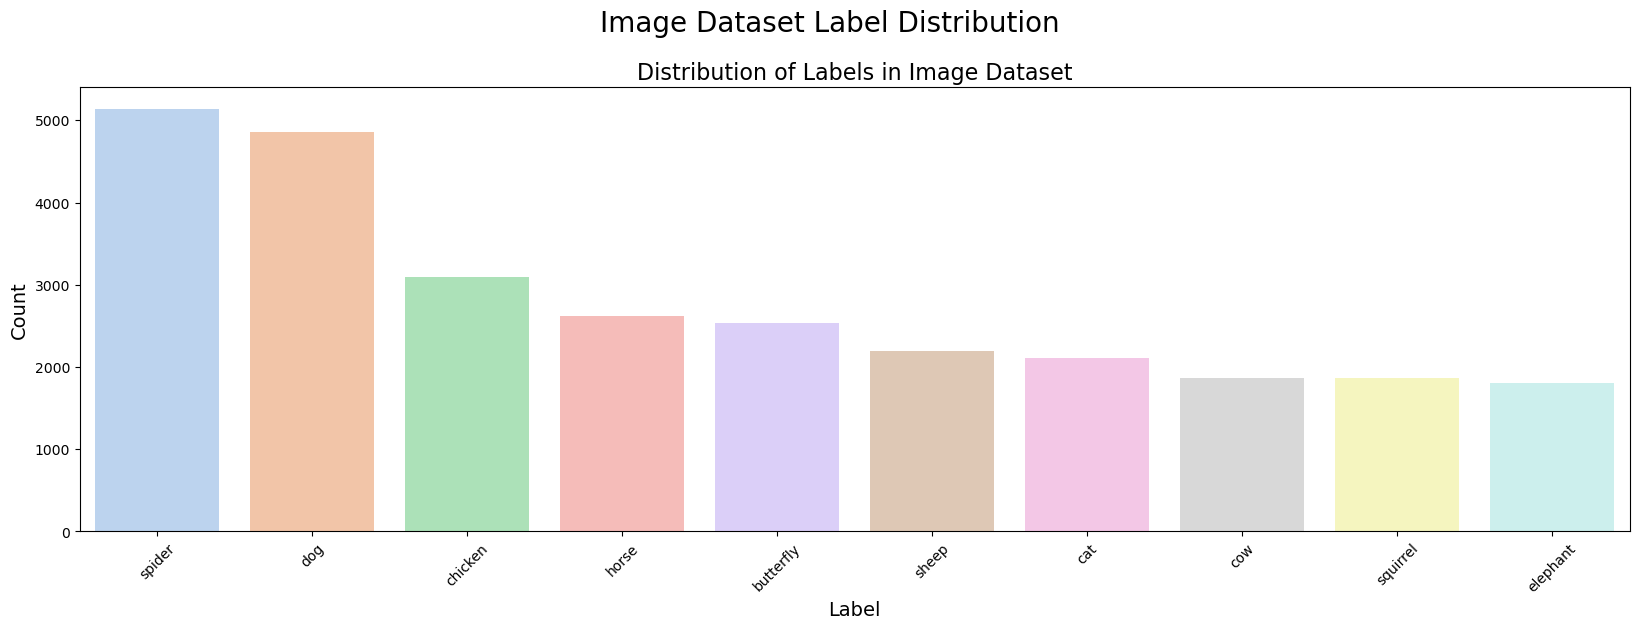

In [9]:
# Get the value counts for each label
label_counts = df["Label"].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show();

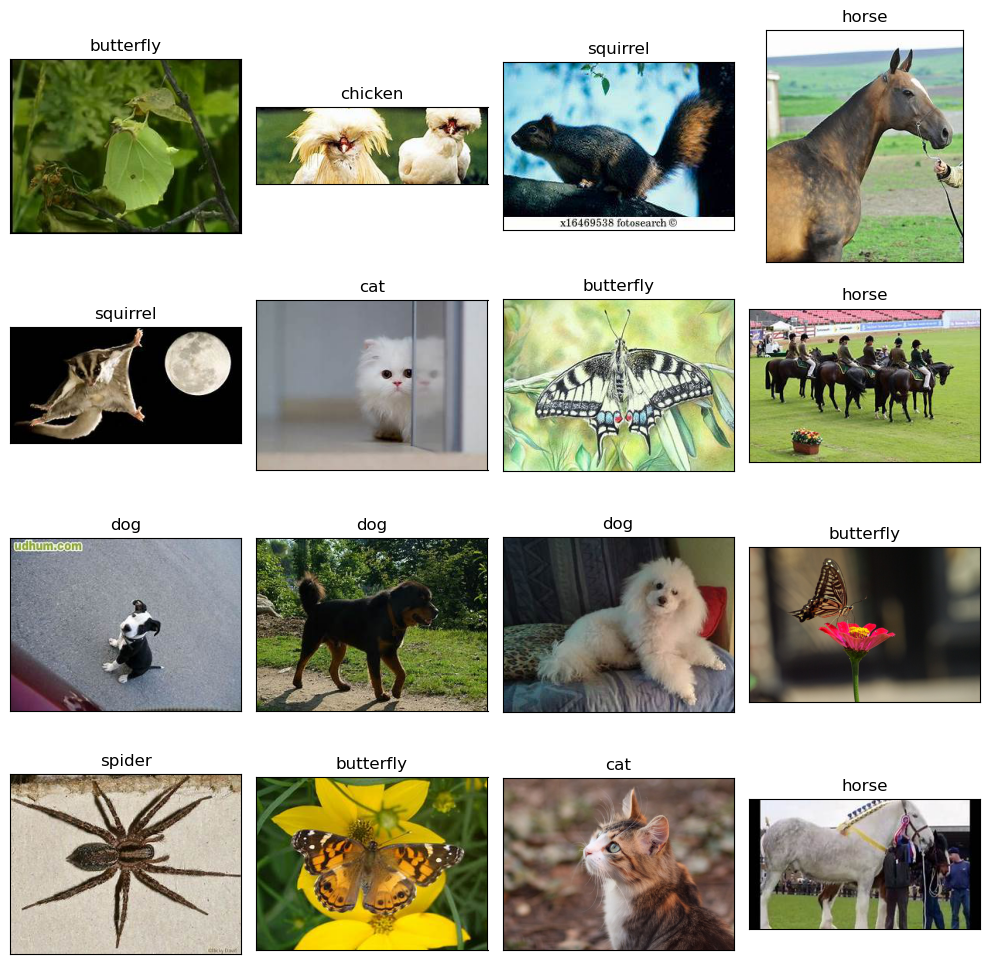

In [10]:
# display random subset of images
random_index = np.random.randint(0, len(df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[random_index[i]]))
    ax.set_title(df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Data Preprocessing

##### The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data

In [11]:
train_df, test_df = train_test_split(df, test_size=0.15, shuffle=True, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.17645, shuffle=True, random_state=42)

In [12]:
train_df.shape, val_df.shape, test_df.shape

((19668, 2), (4215, 2), (4215, 2))

In [13]:
train_df.head()

,Filepath,Label
3815,raw-img\ragno\ec30b90729f01c22d2524518b7444f92...,spider
21992,raw-img\ragno\OIP-3EOKoWWz7ONjj0tVU9WwDwAAAA.jpeg,spider
14626,raw-img\gallina\OIP--Mo8eyE7R8c5nOWdLrxaQwHaFj...,chicken
15141,raw-img\gallina\OIP-b6VD850l80GYxxDVgd4zMAHaHa...,chicken
26180,raw-img\ragno\OIP-_zD8_4qsf9wa_sq81L0IyAHaG6.jpeg,spider


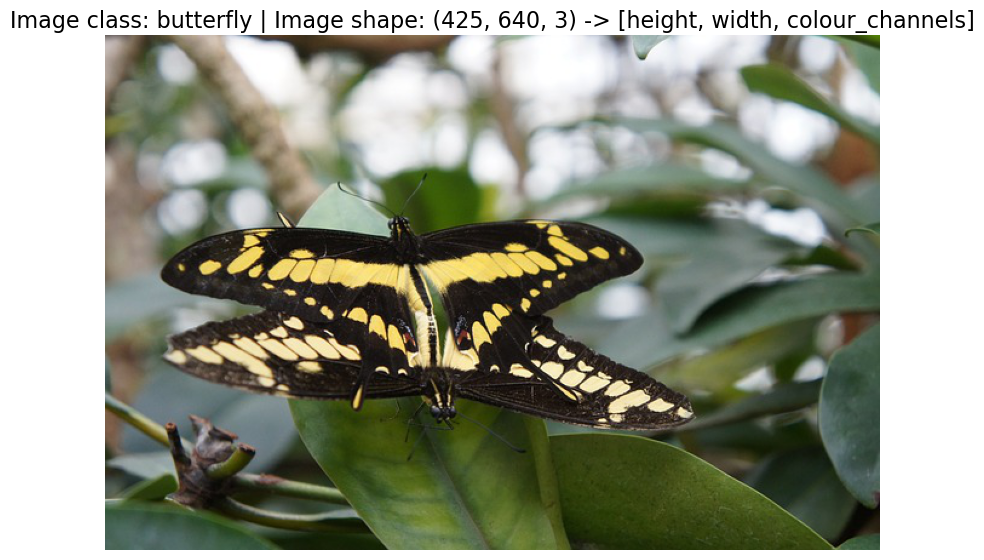

In [22]:
# selecting random images from the training set to display
image_path_list = list(train_df.Filepath)

random_image_path = random.choice(image_path_list)

image_class = train_df[train_df.Filepath == random_image_path].Label.values[0]

img_as_array = np.array(PIL.Image.open(random_image_path))

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, colour_channels]", fontsize=16)
plt.axis(False);

## Data Augmentation

In [15]:
data_augmentation = transforms.Compose([
    # Convert the image to a PyTorch Tensor
    transforms.v2.ToImage(),
    # Use torch.uint8 dtype, especially for resizing
    transforms.v2.ToDtype(torch.uint8, scale=True),
    # Resize the image to 128x128 pixels
    transforms.v2.Resize((256, 256), antialias=True),
    # Crop a square in the center of the image
    transforms.v2.CenterCrop(224),

    transforms.v2.TrivialAugmentWide(31),

    transforms.v2.ToDtype(torch.float32, scale=True),
    # Normalize the image with mean and standard deviation
    transforms.v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.v2.ToImage(),
    transforms.v2.ToDtype(torch.uint8, scale=True),
    transforms.v2.Resize((256, 256), antialias=True),
    transforms.v2.CenterCrop(224),
    transforms.v2.ToDtype(torch.float32, scale=True),
    transforms.v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

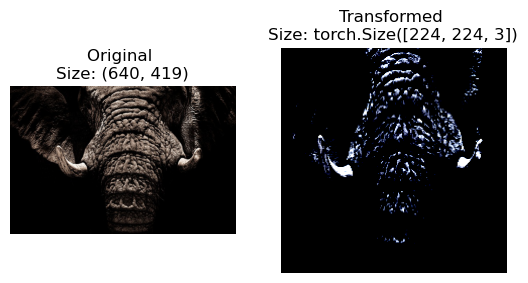

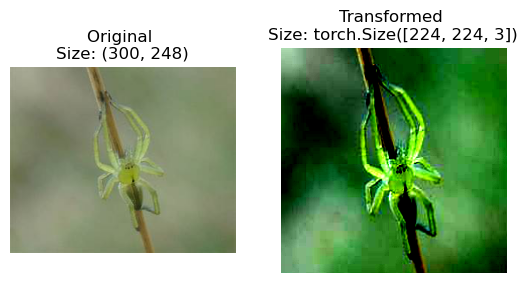

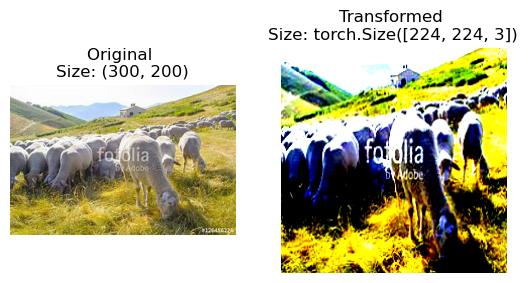

In [21]:
# Display the transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with PIL.Image.open(image_path) as f:
            
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            
            transformed_image = transform(f).permute(1, 2, 0) 
            transformed_image = transformed_image.clamp(0, 1)
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

plot_transformed_images(image_path_list, 
                        transform=data_augmentation, 
                        n=3)

In [17]:
# Create directory for test, train and validation images
train_dir = Path("train/")
val_dir = Path("val/")
test_dir = Path("test/")
train_dir.mkdir(exist_ok=True)
val_dir.mkdir(exist_ok=True)
test_dir.mkdir(exist_ok=True)

# Move images to their respective directories
from shutil import copyfile

def move_images(df, image_dir):
    for i, row in df.iterrows():
        image_path = row.Filepath
        image_class = row.Label

        # Create directory if it doesn't exist
        if not os.path.exists(image_dir / image_class):
            os.makedirs(image_dir / image_class)

        # Move image to directory
        copyfile(image_path, image_dir / image_class / os.path.split(image_path)[1])

move_images(train_df, train_dir)
move_images(val_df, val_dir)
move_images(test_df, test_dir)

In [18]:
walk_dir(train_dir), walk_dir(val_dir), walk_dir(test_dir)

There are 10 directories and 0 images in 'train'.
There are 0 directories and 1591 images in 'train\butterfly'.
There are 0 directories and 1268 images in 'train\cat'.
There are 0 directories and 2136 images in 'train\chicken'.
There are 0 directories and 1304 images in 'train\cow'.
There are 0 directories and 3370 images in 'train\dog'.
There are 0 directories and 1108 images in 'train\elephant'.
There are 0 directories and 1824 images in 'train\horse'.
There are 0 directories and 1336 images in 'train\sheep'.
There are 0 directories and 3417 images in 'train\spider'.
There are 0 directories and 1368 images in 'train\squirrel'.
There are 10 directories and 0 images in 'val'.
There are 0 directories and 343 images in 'val\butterfly'.
There are 0 directories and 312 images in 'val\cat'.
There are 0 directories and 497 images in 'val\chicken'.
There are 0 directories and 288 images in 'val\cow'.
There are 0 directories and 735 images in 'val\dog'.
There are 0 directories and 249 images i

(None, None, None)